<a href="https://colab.research.google.com/github/gabrielnichio/Deep-Learning-Learning/blob/main/DataLoading_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with customized data

Dataset used from UCI, used to predict the number of bikes that are going to be rented in the next hour.

In [20]:
import torch
import numpy as np
import pandas as pd
import time
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [21]:
args = {
    'epoch_num': 200,
    'lr': 5e-5,
    'weight_decay': 5e-4,
    'num_workers': 3,
    'batch_size': 20,
}

args['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(args['device'])

cuda


## Downloading the dataset

In [22]:
!wget https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip

--2024-11-26 12:32:50--  https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bike+sharing+dataset.zip.1’

bike+sharing+datase     [ <=>                ] 273.43K  --.-KB/s    in 0.04s   

2024-11-26 12:32:50 (7.11 MB/s) - ‘bike+sharing+dataset.zip.1’ saved [279992]



In [23]:
!unzip bike+sharing+dataset.zip

Archive:  bike+sharing+dataset.zip
replace Readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [24]:
!ls

bike+sharing+dataset.zip    day.csv   Readme.txt   test_set.csv
bike+sharing+dataset.zip.1  hour.csv  sample_data  train_set.csv


In [25]:
df = pd.read_csv('/content/hour.csv')
print(df.shape)
df.head()

(17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [26]:
torch.manual_seed(1)

indexes = torch.randperm(len(df)).tolist()

train_size = int(len(df)*0.8)

train_set = df.iloc[indexes[:train_size]]
test_set = df.iloc[indexes[train_size:]]

train_set.to_csv('train_set.csv')
test_set.to_csv('test_set.csv')

# Dataset method from pytorch

Used to transform a custom dataset to a proper one that can be used with pytorch MLP

- Methods:
 - __init__(self): define the samples
 - __getitem__(self, idx): load the sample, apply transformations and output a tuple (data, label)
 - __len__(self): returns the number of samples

In [27]:
class Bike(Dataset):
  def __init__(self, path_name):

    self.data = pd.read_csv(path_name).to_numpy()

  def __getitem__(self, idx):

    sample = self.data[idx][3:15]
    label = self.data[idx][-1:]

    sample = torch.from_numpy(sample.astype(np.float32))
    label  = torch.from_numpy(label.astype(np.float32))

    return sample, label

  def __len__(self):
    return len(self.data)

In [28]:
train_set = Bike('train_set.csv')
test_set = Bike('test_set.csv')

#Data Loader

In [29]:
train_loader = DataLoader(train_set,
                          args['batch_size'],
                          num_workers=args['num_workers'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         num_workers=args['num_workers'],
                         shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Implementing MLP

In [30]:
class MLP(nn.Module):

  def __init__(self, input_size, hidden_size, out_size):
    super(MLP, self).__init__()

    self.features = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, hidden_size),
          nn.ReLU(),
    )

    self.classifier = nn.Sequential(
        nn.Linear(hidden_size, out_size),
        nn.ReLU(),
    )

  def forward(self, X):

    hidden = self.features(X)
    output = self.classifier(hidden)

    return output

input_size  = train_set[0][0].size(0)
hidden_size = 128
out_size    = 1

net = MLP(input_size, hidden_size, out_size).to(args['device'])
print(net)

MLP(
  (features): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): ReLU()
  )
)


# Loss and optimizer

In [31]:
criterion = nn.L1Loss().to(args['device'])

optimizer = optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

# Training

In [32]:
def train(train_loader, net, epoch):
  net.train()

  epoch_loss = []

  init = time.time()

  for batch in train_loader:
    data, label = batch

    data = data.to(args['device'])
    label = label.to(args['device'])

    pred = net(data)
    loss = criterion(pred, label)
    epoch_loss.append(loss.cpu().data)

    loss.backward()
    optimizer.step()

  end = time.time()
  epoch_loss = np.asarray(epoch_loss)

  print(f'Epoch: {epoch}, epoch_mean: {epoch_loss.mean():.2f}, epoch_std: {epoch_loss.std():.2f}, time: {end-init:.4f}')

  return epoch_loss.mean()

# Validation

In [33]:
def validation(test_loader, net, epoch):

  net.eval()

  epoch_loss = []

  init = time.time()

  with torch.no_grad():

    for batch in test_loader:
      data, label = batch

      data = data.to(args['device'])
      label = label.to(args['device'])

      pred = net(data)
      loss = criterion(pred, label)
      epoch_loss.append(loss.cpu().data)

    end = time.time()
    epoch_loss = np.asarray(epoch_loss)

    print(f'Epoch: {epoch}, epoch_mean: {epoch_loss.mean():.2f}, epoch_std: {epoch_loss.std():.2f}, time: {end-init:.4f}')

    return epoch_loss.mean()

In [35]:
train_losses, test_losses = [], []

for epoch in range(args["epoch_num"]):

  train_losses.append(train(train_loader, net, epoch))

  test_losses.append(validation(test_loader, net, epoch))

  print('\n-------------------\n')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 0, epoch_mean: 189.57, epoch_std: 40.65, time: 2.3705
Epoch: 0, epoch_mean: 188.64, epoch_std: 38.76, time: 0.4611

-------------------

Epoch: 1, epoch_mean: 189.71, epoch_std: 42.45, time: 2.4894
Epoch: 1, epoch_mean: 188.64, epoch_std: 38.76, time: 0.6397

-------------------

Epoch: 2, epoch_mean: 189.61, epoch_std: 41.22, time: 2.7231
Epoch: 2, epoch_mean: 188.64, epoch_std: 38.76, time: 0.4393

-------------------

Epoch: 3, epoch_mean: 189.76, epoch_std: 40.86, time: 2.2855
Epoch: 3, epoch_mean: 188.64, epoch_std: 38.76, time: 0.4410

-------------------

Epoch: 4, epoch_mean: 189.61, epoch_std: 40.01, time: 2.3034
Epoch: 4, epoch_mean: 188.64, epoch_std: 38.76, time: 0.4492

-------------------

Epoch: 5, epoch_mean: 189.72, epoch_std: 39.21, time: 2.3269
Epoch: 5, epoch_mean: 188.64, epoch_std: 38.76, time: 0.4616

-------------------

Epoch: 6, epoch_mean: 189.76, epoch_std: 41.15, time: 3.0538
Epoch: 6, epoch_mean: 188.64, epoch_std: 38.76, time: 0.4595

-------------

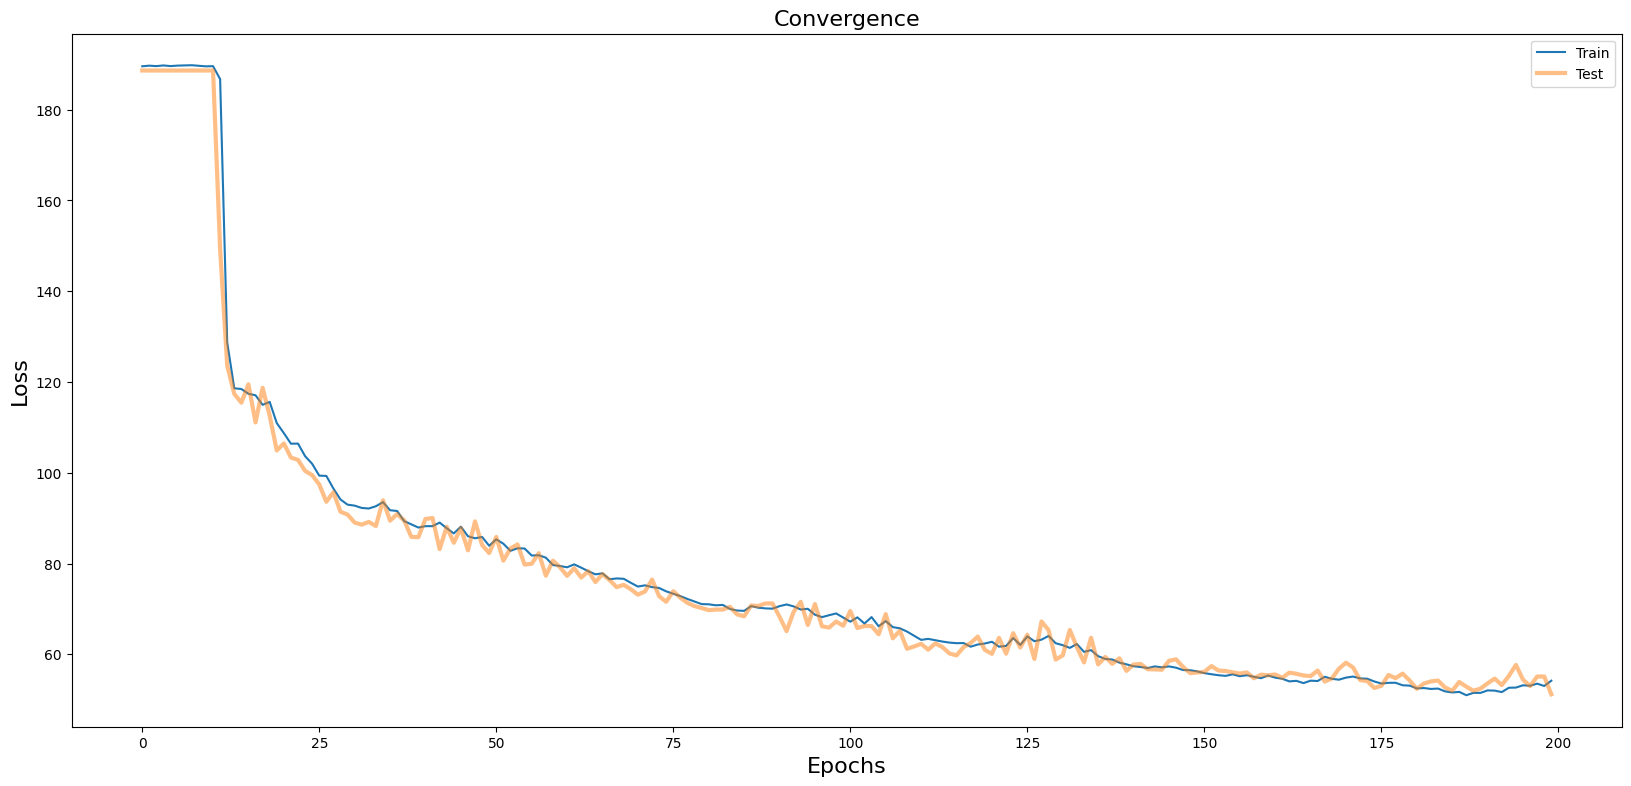

In [36]:
plt.figure(figsize=(20, 9))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergence', fontsize=16)
plt.legend()
plt.show()